In [1]:
import os

# Set the TensorFlow logging level to suppress INFO, WARNING, and ERROR messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import absl.logging

# Set the absl logging level to ERROR
absl.logging.set_verbosity(absl.logging.ERROR)

# from tensorflow.keras import layers, models
from keras import layers, models

# Check if GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("Using GPU")
else:
    print("Using CPU")

2024-07-29 17:18:56.907986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 17:18:56.984774: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 17:18:57.004735: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using GPU


I0000 00:00:1722253739.421005    2097 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722253739.579031    2097 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722253739.579087    2097 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
import os
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
data_dir = Path('data')
male_voices_path = data_dir / 'males'
female_voices_path = data_dir / 'females'

male_voices = list(map(str, male_voices_path.glob('*.wav')))
female_voices = list(map(str, female_voices_path.glob('*.wav')))
audio_paths = male_voices + female_voices
len(male_voices), len(female_voices), len(audio_paths)

(3682, 2311, 5993)

In [95]:
@tf.function
def load_wav(filename):
    if isinstance(filename, bytes):
        filename = filename.decode('utf-8')
        
    # tf.print(f"Loading file: {filename}")
    file_content = tf.io.read_file(filename=filename)
    wav, sample_rate = tf.audio.decode_wav(file_content, desired_channels=1)
    # removing tailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # goes from 44100Hz to 16000 Hz
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

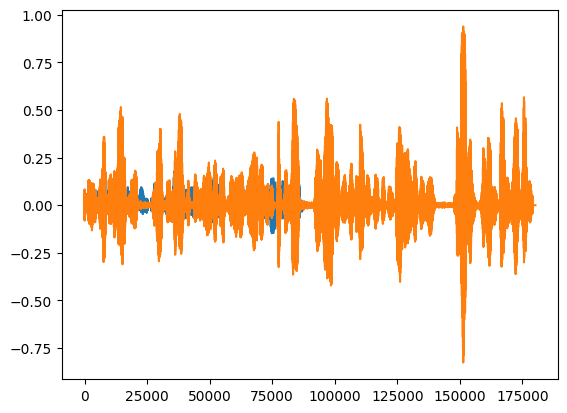

In [96]:
wav_m = load_wav(male_voices[0])
wav_f = load_wav(female_voices[0])
plt.plot(wav_m)
plt.plot(wav_f)
plt.show();

# Creating TF Dataset

In [6]:
male_voices_path = "data/males"
female_voices_path = "data/females"

voices_m = tf.data.Dataset.list_files(male_voices_path+'/*.wav')
voices_f = tf.data.Dataset.list_files(female_voices_path+'/*.wav')

In [7]:
voices_m.as_numpy_iterator().next()

b'data/males/2807.wav'

# Adding Labels
- 1 -> Males
- 0 -> Females

In [97]:
males = tf.data.Dataset.zip((voices_m, tf.data.Dataset.from_tensor_slices(tf.ones(len(voices_m)))))
females = tf.data.Dataset.zip((voices_f, tf.data.Dataset.from_tensor_slices(tf.zeros(len(voices_f)))))
data = males.concatenate(females)

In [98]:
data.shuffle(3000).as_numpy_iterator().next()

(b'data/males/959.wav', 1.0)

# EDA
- hahaha

In [141]:
audio_paths = list(map(str, audio_paths))

lengths = []
for file in audio_paths:
    t_wav = load_wav(file)
    lengths.append(len(t_wav))

In [143]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=111928>

In [144]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=63488>

In [145]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=1456128>

# Preprocessing

In [102]:
@tf.function
def preprocess(filepath, label):
    wav = load_wav(filepath)
    wav = wav[:63488]
    zero_padding = tf.zeros([63488] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    spectogram = tf.signal.stft(wav, frame_length=320, frame_step=32) # shrot time furriar transform
    spectogram = tf.abs(spectogram)
    spectogram = tf.expand_dims(spectogram, axis=2)
    return spectogram, label

In [99]:
data.as_numpy_iterator().next()

(b'data/males/3135.wav', 1.0)

In [100]:
@tf.function
def preprocess_mfcc(filename, label):
    pcm = load_wav(filename)
    pcm = pcm[:63488]
    zero_padding = tf.zeros([63488] - tf.shape(pcm), dtype=tf.float32)
    pcm = tf.concat([zero_padding, pcm], 0)

    stfts = tf.signal.stft(pcm, frame_length=320, frame_step=32)
    stfts = tf.expand_dims(stfts, axis=2)
    spectogram = tf.abs(stfts)
    
    num_spectogram_bins = stfts.shape[-1]
    if num_spectogram_bins is None:
        print(pcm)
        raise ValueError("num_spectogram_bins is None. Check the input signal length and STFT parameters.")

    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 40
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=num_mel_bins,
        num_spectrogram_bins=num_spectogram_bins,
        sample_rate=16000,
        lower_edge_hertz=lower_edge_hertz,
        upper_edge_hertz=upper_edge_hertz
    )
    mel_spectogram = tf.tensordot(
        spectogram,
        linear_to_mel_weight_matrix,
        1
    )
    mel_spectogram.set_shape(spectogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))
    log_mel_spectogram = tf.math.log(mel_spectogram + 1e-6)

    mfcc = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectogram)[..., :13]

    return mfcc, label

In [104]:
data.map(preprocess).as_numpy_iterator().next()[0].shape

(1975, 257, 1)

In [14]:
def plot_spec(dataset):
    filepath, label = dataset.shuffle(buffer_size=10000).as_numpy_iterator().next()

    spectogram, label = preprocess(filepath=filepath, label=label)
    print(spectogram.shape)

    plt.figure(figsize=(30, 20))
    plt.imshow(tf.transpose(spectogram)[0])
    plt.show();

(1975, 257, 1)


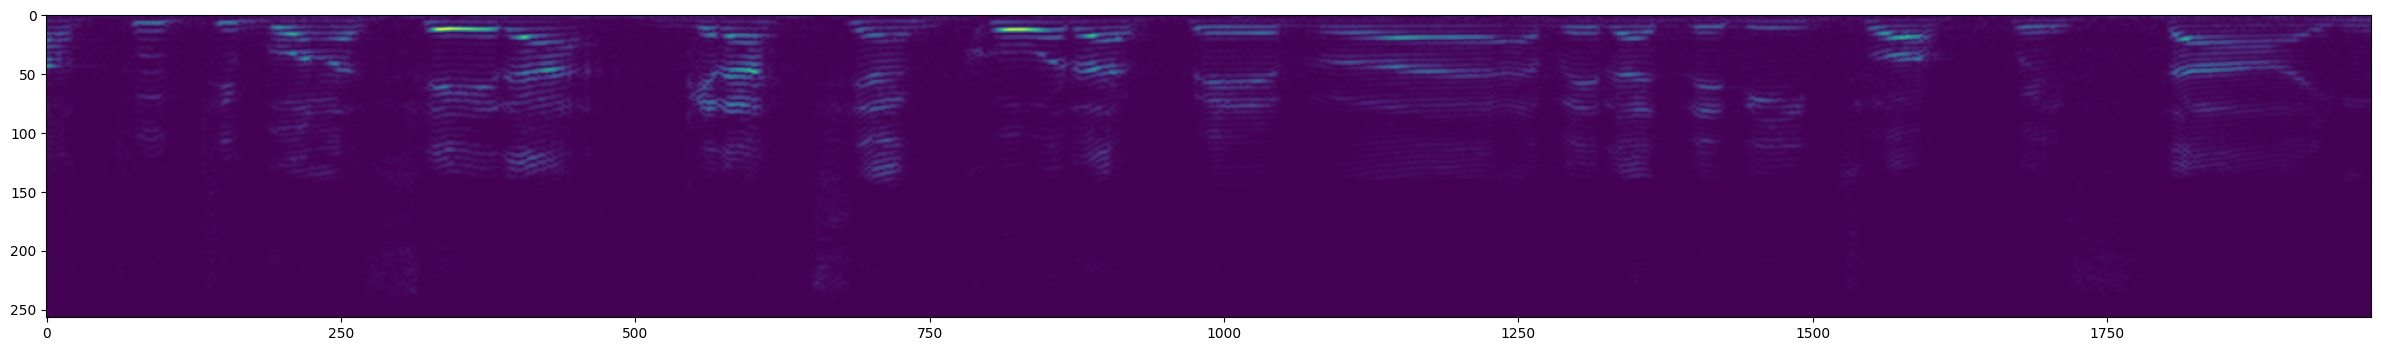

(1975, 257, 1)


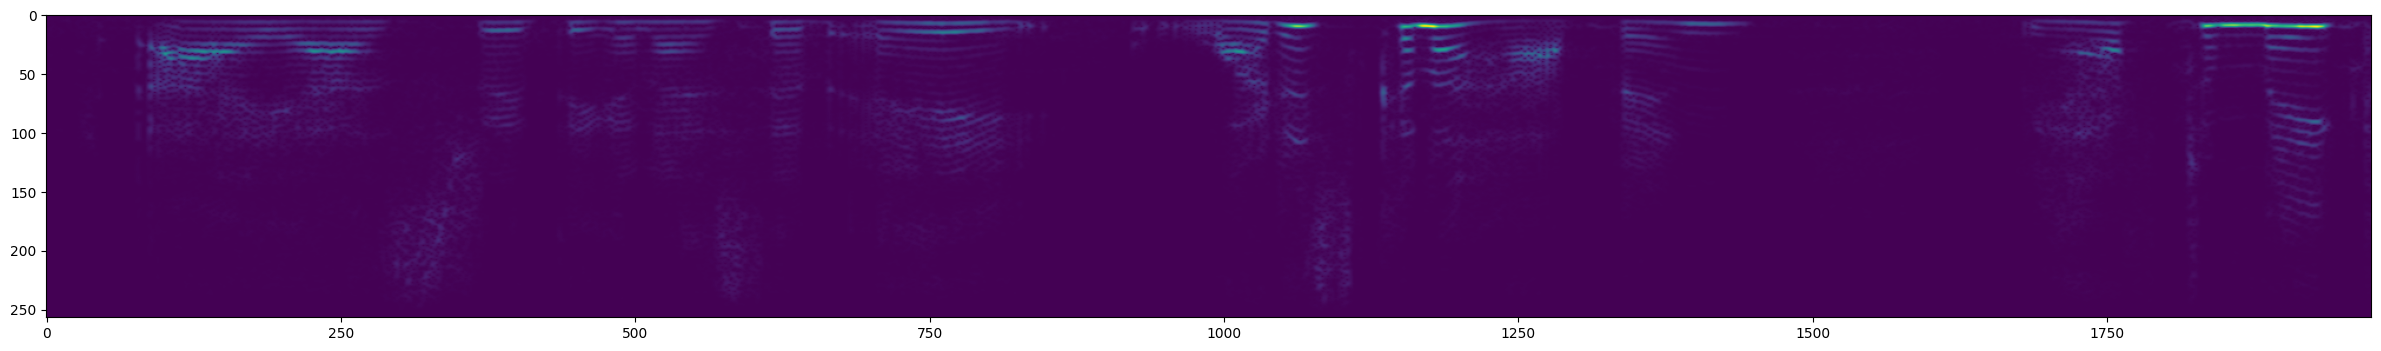

In [15]:
plot_spec(males)
plot_spec(females)

# Create TF Data Pipeline

In [16]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=500)
data = data.batch(16)
data = data.prefetch(8)

In [17]:
train = data.take(262)
test = data.skip(263).take(113)

In [18]:
samples, labels = train.as_numpy_iterator().next()
samples.shape, labels.shape

((16, 1975, 257, 1), (16,))

# Deep Learning Model

In [19]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Input

In [20]:
model = Sequential()
# model.add(Input)
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(1975, 257, 1)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='relu'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1973, 255, 16)  │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 1971, 253, 16)  │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7978608)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │   127,657,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,660,241 (486.99 MB)

 Trainable params: 127,660,241 (486.99 MB)

 Non-trainable params: 0 (0.00 B)